Import Required Packages

In [4]:
!pip install torch torchvision
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

  Cloning https://github.com/luca-medeiros/lang-segment-anything.git to /tmp/pip-req-build-w68s4g3x
  Running command git clone --filter=blob:none --quiet https://github.com/luca-medeiros/lang-segment-anything.git /tmp/pip-req-build-w68s4g3x
  Resolved https://github.com/luca-medeiros/lang-segment-anything.git to commit fcdb92f9ae4ac3a5b4e5fd85c1576e09132f10bc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-install-2u12aq_u/groundingdino_19615eca2a3e413f856b5702eb7e57eb
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-install-2u12aq_u/groundingdino_19615eca2a3e413f856b5702eb7e57eb
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 60d796825e1266e56f7e4e9e00e88de662b67bd3
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fac

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:10<00:00, 242MB/s]


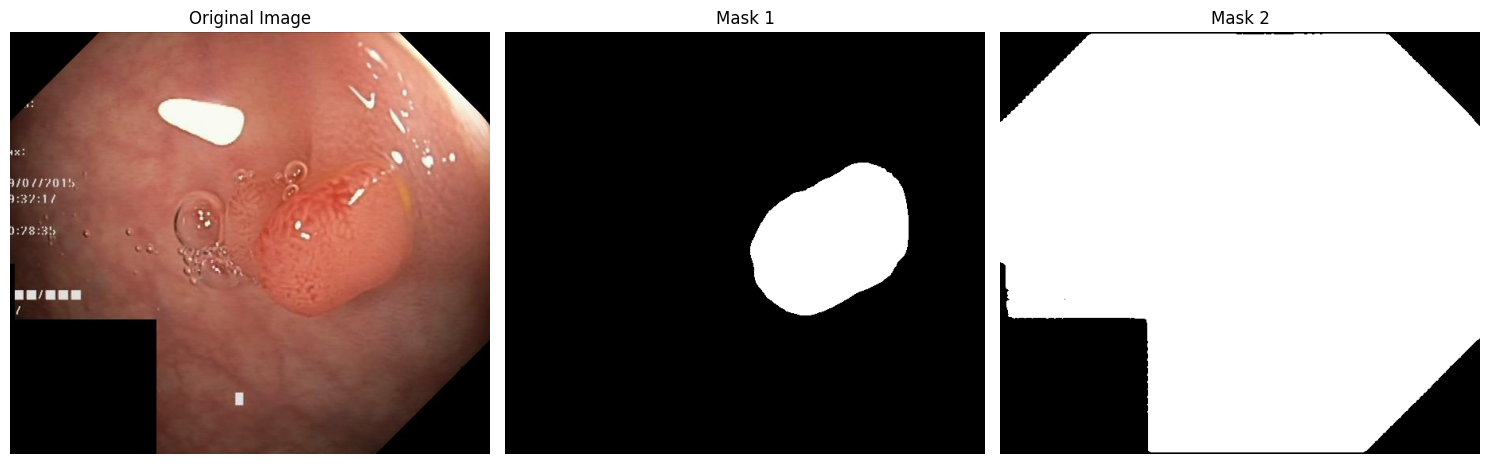

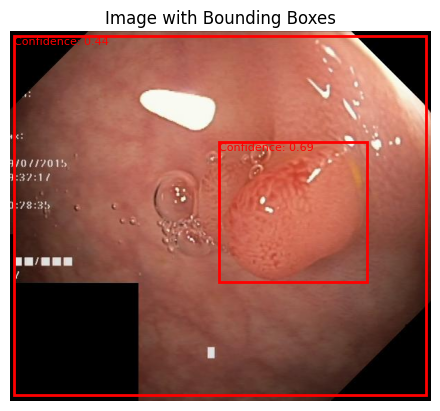

Bounding Boxes:
Box 1: tensor([299.2802, 157.7175, 511.0262, 358.6717])
Box 2: tensor([  5.1122,   6.1366, 596.4928, 520.9409])

Detected Phrases:
Phrase 1: a polyp
Phrase 2: multiple polyps

Confidence:
Logit 1: 0.6904764175415039
Logit 2: 0.4398995339870453


In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM

image = "/content/cju2qz06823a40878ojcz9ccx.png"

text_prompt = """
A polyp is an anomalous ovalshaped small bump-like structure, a relatively small growth or
mass that develops on the inner lining of the colon or other organs.
Multiple polyps may exist in one image.
"""


def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = f"image_mask_{i+1}.png"
                save_mask(mask_np, mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

In [ ]:
!rm -rf /content/Clinic-DB_mask_output

Batch Processing

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import os
from lang_sam import LangSAM
# (import your actual LangSAM class if it's located in a different module)

# The path to the folder containing images
image_folder = "/content/CVC-300"

text_prompt = """A polyp is an anomalous oval shaped small bump like structure, relatively small growth or mass that develops on the inner lining of the colon or other organs.
Multiple ployps may exist in one image
"""

def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    # Create a folder for saving masks if it doesn't exist
    if not os.path.exists("CVC-300_mask_output"):
        os.makedirs("CVC-300_mask_output")

    try:
        # Get a list of image files in the folder
        image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(".png")]

        if len(image_files) == 0:
            print("No PNG images found in the specified folder.")
            return

        model = LangSAM()

        for image_file in image_files:
            image_path = os.path.join(image_folder, image_file)
            image_pil = Image.open(image_path).convert("RGB")

            masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

            if len(masks) == 0:
                print(f"No objects of the '{text_prompt}' prompt detected in {image_file}.")
            else:
                # Convert masks to numpy arrays
                masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

                # Display the original image and masks side by side
                display_image_with_masks(image_pil, masks_np)

                # Display the image with bounding boxes and confidence scores
                display_image_with_boxes(image_pil, boxes, logits)

                # Save the masks
                for i, mask_np in enumerate(masks_np):
                    mask_filename = f"CVC-300_mask_output/{image_file}_mask_{i+1}.png"
                    save_mask(mask_np, mask_filename)

                # Print the bounding boxes, phrases, and logits
                print_bounding_boxes(boxes)
                print_detected_phrases(phrases)
                print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

Zip and Download the Folder

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!zip -r /content/CVC-300_mask_output.zip /content/CVC-300_mask_output